In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset, concatenate_datasets

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import numpy as np

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

import evaluate 

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay


In [2]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {label: i for i, label in enumerate(set(df['train']['labels']))}
id2label = {i: label for i, label in enumerate(set(df['train']['labels']))}

HF google storage unreachable. Downloading and preparing it from source


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
id2label

{0: 'primary_progressive_multiple_sclerosis',
 1: 'relapsing_remitting_multiple_sclerosis',
 2: 'secondary_progressive_multiple_sclerosis'}

In [4]:
# Subsample stratisfied by label
df['train'] = concatenate_datasets([df['train'].filter(lambda example: example['labels'] == 'primary_progressive_multiple_sclerosis'), 
                                     df['train'].filter(lambda example: example['labels'] == 'secondary_progressive_multiple_sclerosis'),
                                     df['train'].filter(lambda example: example['labels'] == "relapsing_remitting_multiple_sclerosis").select(range(0,20))])

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

In [ ]:
# # Run this cell if you want to download and fine-tune the model
# from huggingface_hub import notebook_login

# # Login to Hugging Face Hub as model is gated
# notebook_login()

# # Checkpoint
# checkpoint = "GerMedBERT/medbert-512"

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# # Save tokenizer
# tokenizer.save_pretrained(paths.MODEL_PATH/'medbert')

# # Load model for embedding
# model = AutoModel.from_pretrained(checkpoint)

# # Save model
# model.save_pretrained(paths.MODEL_PATH/'medbert')

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt')

    return data

# Tokenize dataset
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

In [7]:
# Training arguments
EPOCHS = 15
BATCH_SIZE = 16
TRAIN_STEPS = EPOCHS * len(dataset['train']) // BATCH_SIZE

# Collator
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

# Dataloader
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Accelerator
accelerator = Accelerator(mixed_precision='fp16')

# Optimizer and scheduler
optim = AdamW(model.parameters(), lr=1e-6)
lr_scheduler = get_scheduler(
    "linear",
    optim,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

#f1_metric = evaluate.load("f1")

# Class weights
power = 1
class_weights = [1/np.log(len(dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(dataset['train']['labels'])]
class_weights = [weight**power for weight in class_weights]
class_weights = torch.tensor(class_weights, dtype=torch.float)


loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

# Prepare with accelerator
model, optim, train_loader, val_loader, test_loader, loss_fun = accelerator.prepare(
    model, optim, train_loader, val_loader, test_loader, loss_fun
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Filter:   0%|          | 0/33 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33 [00:00<?, ? examples/s]

In [8]:
class_weights

tensor([0.4809, 0.3338, 0.6213])

In [9]:
# Training
torch.manual_seed(42)
progress_bar = tqdm.tqdm(range(TRAIN_STEPS))

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        outputs = model(**batch)
        loss = loss_fun(outputs.logits, batch['labels'])
        accelerator.backward(loss)
        optim.step()
        lr_scheduler.step()
        progress_bar.update(1)

    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        val_loss = 0
        acc = 0
        for batch in val_loader:
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            
            val_loss += loss_fun(outputs.logits, batch['labels'])
            acc += (predictions == batch['labels']).sum().item()
            
            preds.extend(predictions.tolist())
            labels.extend(batch['labels'].tolist())

    f1 = f1_score(labels, preds, average='weighted')
    if epoch == 0:
            min_val_loss = val_loss
    elif epoch >= 5 & (val_loss < min_val_loss):
        min_val_loss = val_loss
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert')

    print(f"Epoch {epoch+1}: F1 score: {f1} Loss: {val_loss/len(val_loader)} Accuracy: {acc/len(dataset['validation'])}")

 13%|█▎        | 4/30 [00:13<00:56,  2.17s/it]

Epoch 1: F1 score: 0.01098901098901099 Loss: 1.1168190240859985 Accuracy: 0.07142857142857142


 23%|██▎       | 7/30 [00:15<00:24,  1.06s/it]

Epoch 2: F1 score: 0.4511278195488722 Loss: 1.093677043914795 Accuracy: 0.35714285714285715


 33%|███▎      | 10/30 [00:16<00:12,  1.57it/s]

Epoch 3: F1 score: 0.6233766233766234 Loss: 1.0751813650131226 Accuracy: 0.5714285714285714


 43%|████▎     | 13/30 [00:17<00:08,  2.04it/s]

Epoch 4: F1 score: 0.7542857142857142 Loss: 1.065490961074829 Accuracy: 0.7857142857142857


 53%|█████▎    | 16/30 [00:18<00:06,  2.32it/s]

Epoch 5: F1 score: 0.7542857142857142 Loss: 1.0587817430496216 Accuracy: 0.7857142857142857


 63%|██████▎   | 19/30 [00:19<00:04,  2.62it/s]

Epoch 6: F1 score: 0.7542857142857142 Loss: 1.0522735118865967 Accuracy: 0.7857142857142857


 67%|██████▋   | 20/30 [00:19<00:03,  2.98it/s]

Epoch 7: F1 score: 0.7542857142857142 Loss: 1.0479764938354492 Accuracy: 0.7857142857142857


 83%|████████▎ | 25/30 [00:55<00:17,  3.54s/it]

Epoch 8: F1 score: 0.7542857142857142 Loss: 1.0435985326766968 Accuracy: 0.7857142857142857


 93%|█████████▎| 28/30 [00:56<00:03,  1.90s/it]

Epoch 9: F1 score: 0.7912087912087912 Loss: 1.0406850576400757 Accuracy: 0.8571428571428571


31it [00:57,  1.13s/it]                        

Epoch 10: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


34it [00:59,  1.30it/s]

Epoch 11: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


37it [00:59,  1.85it/s]

Epoch 12: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


40it [01:00,  2.32it/s]

Epoch 13: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


43it [01:01,  2.63it/s]

Epoch 14: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


44it [01:01,  2.99it/s]

Epoch 15: F1 score: 0.7912087912087912 Loss: 1.039419174194336 Accuracy: 0.8571428571428571


In [10]:
torch.cuda.empty_cache()

# Predictions
predictions = []
labels = []
#f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        #f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

#f1_score = f1_test.compute(average='weighted')
#print("F1", f1_score)


100%|██████████| 4/4 [00:00<00:00, 16.57it/s]


F1 Score: 0.7907492475843497
Precision: 0.7691833590138675
Recall: 0.8135593220338984


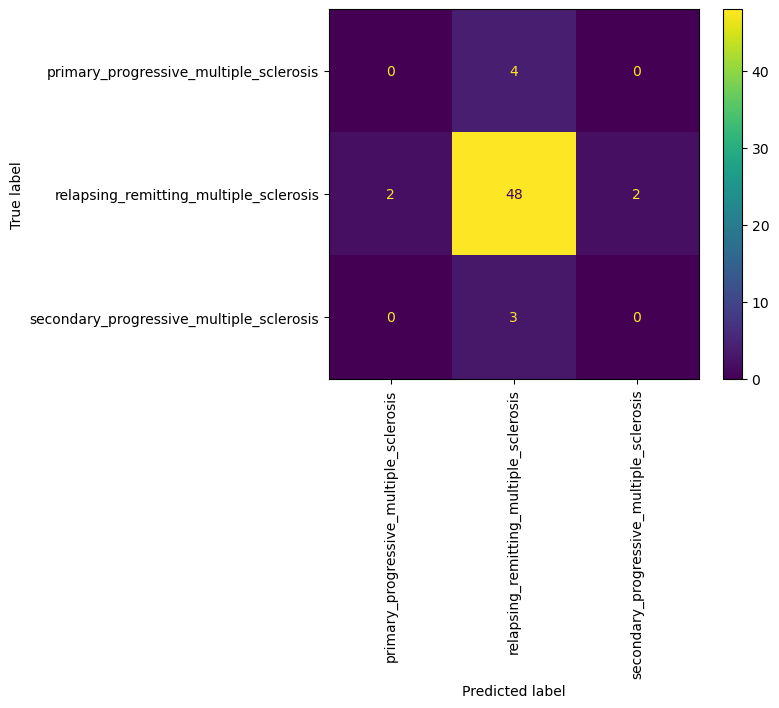

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='weighted')}")
print(f"Precision: {precision_score(labels, predictions, average='weighted')}")
print(f"Recall: {recall_score(labels, predictions, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

In [19]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
for i, label in enumerate(labels):
    if label != predictions[i]:
        print("Label", id2label[label])
        print("Predicted", id2label[predictions[i]])
        print("Text: ", df_test.iloc[i]["text"])

Label secondary_progressive_multiple_sclerosis
Predicted relapsing_remitting_multiple_sclerosis
Text:  Multiple Sklerose sekundär progredient mit überlagernden Schüben, EM 2005 ED 2006 EDSS 4.0 aktuell: klinisch aktiv, radiologisch nicht aktiv, Progression ja (nach Lublin et al. 2013) neu aufgetretene Sensibilitätsstörung linker Fuss seit Mitte Juni mit unvollständiger Rückbildung unter Cortison Verlauf:  Retrobulbärneuritis im linken Auge 2005.  drei Monate später (2005) in beiden Händen Sensibilitätsstörungen erneut ca. drei Monate später Sensibilitätsstörungen der Zunge und der rechten Gesichtshälfte 2006 - 2009 stabiler Verlauf ohne Beschwerden ab 2009 Mühe mit Rennen, ab 2013 progrediente Gangstörung mit Spastik 12/16 fraglicher Schub mit Verschlechterung der Gangstörung, Cortisongabe in Italien 06/2019: Schub mit Hypästhesie des linken Fusses und zweimaliger Cortisonstosstherapie Diagnostisch oligoklonale Banden im Liquor positiv, Aquaporin-4-AK negativ; immunologisches Screening